In [29]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
from scipy import stats
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

educ_center                                                        0
harass5_Does not apply (i do not have a job/superior/co-worker)    0
harass5_No                                                         0
harass5_Yes                                                        0
polviews_Conservative                                              0
polviews_Extremely liberal                                         0
polviews_Extrmly conservative                                      0
polviews_Liberal                                                   0
polviews_Moderate                                                  0
polviews_Slghtly conservative                                      0
polviews_Slightly liberal                                          0
advfront_Agree                                                     0
advfront_Disagree                                                  0
advfront_Dont know                                                 0
advfront_Strongly agree           

/tmp/ipykernel_29096/1155444939.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


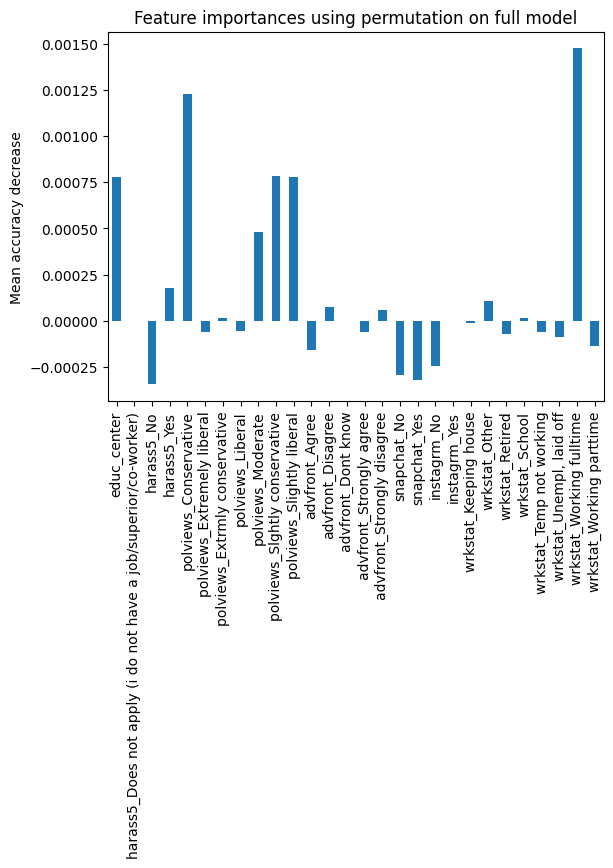

In [30]:

X = pd.read_csv("data/preprocessing/X.csv")
y = pd.read_csv("data/preprocessing/y.csv")["email_time_center"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.isna().sum())

result_df = pd.DataFrame()

feature_names = list(X_train.columns)
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Vẽ biểu đồ với cột tìm được.
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


In [31]:

# Thử xây dựng mô hình RandomForest với 5 feature có ảnh hưởng đến mô hình.
def feature_selection(X_train, y_train, seed: int):
    forest = RandomForestRegressor(random_state=seed)
    scores = cross_val_score(forest, X_train, y_train,
                              cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False))
    print(f"CV mean score: {np.mean(scores)}")

    return scores

top_feature_choice = [
    "wrkstat_Working fulltime",
    "polviews_Conservative",
    "educ_center",
    "polviews_Slghtly conservative",
    "polviews_Slightly liberal",
    "polviews_Moderate"
]


for i in range(1, len(top_feature_choice)):
    X_top_feature = X[top_feature_choice[:i]]
    X_train, X_test, y_train, y_test = train_test_split(X_top_feature, y, random_state=0)
    print(f"Feature: {top_feature_choice[:i]}")
    feature_selection(X_train, y_train, i)

# Nhận xét: Chọn 2 feature đầu là hợp lý nhất.

Feature: ['wrkstat_Working fulltime']
CV mean score: -0.01306883988682453
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative']
CV mean score: -0.013074980557517546
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center']
CV mean score: -0.013198902252206744
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center', 'polviews_Slghtly conservative']
CV mean score: -0.013613536014302628
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center', 'polviews_Slghtly conservative', 'polviews_Slightly liberal']
CV mean score: -0.013461901319601283


In [32]:
# Thực hiện tìm tham số phù hợp.
# Thử xây dựng mô hình RandomForest với 5 feature có ảnh hưởng đến mô hình.
def tune_hyperparams(X_train, y_train, seed: int):
    distributions = dict(
        n_estimators=[128, 256, 512],
        max_depth=[2, 3, 4, 5],

    )
    forest = RandomForestRegressor(random_state=seed)
    clf = GridSearchCV(forest, distributions, 
                       scoring=make_scorer(mean_squared_error, greater_is_better=False))
    search = clf.fit(X_train, y_train)
    print(f"Best params: {search.best_params_}")
    print(f"Best score: {search.best_score_}")
    return search

top_feature_choice = [
    "wrkstat_Working fulltime",
    "polviews_Conservative",
    "educ_center",
    "polviews_Slghtly conservative",
    "polviews_Slightly liberal",
    "polviews_Moderate"
]


for i in range(1, len(top_feature_choice)):
    X_top_feature = X[top_feature_choice[:i]]
    X_train, X_test, y_train, y_test = train_test_split(X_top_feature, y, random_state=0)
    print(f"Feature: {top_feature_choice[:i]}")
    tune_hyperparams(X_train, y_train, i)

# Nhận xét: Chọn 2 feature đầu là hợp lý nhất.

Feature: ['wrkstat_Working fulltime']
Best params: {'max_depth': 2, 'n_estimators': 256}
Best score: -0.013066604544439891
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.01307104622531075
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.012766072129229162
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center', 'polviews_Slghtly conservative']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.012766227839119107
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center', 'polviews_Slghtly conservative', 'polviews_Slightly liberal']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.012772894512980216


In [34]:
# Build mô hình cuối cùng, test và in kết quả.
def final_model(X_train, y_train, X_test, y_test, seed: int):
    forest = RandomForestRegressor(random_state=seed, max_depth=2, n_estimators=128)
    forest.fit(X_train, y_train)
    mse = mean_squared_error(y_test, forest.predict(X_test))
    rmse = mean_squared_error(y_test, forest.predict(X_test), squared=False)
    print(f"Test MSE: {mse}")
    print(f"Test RMSE: {rmse}")
    print(f"Mean y: {np.mean(y_test)}")

feature_choice = [
    "wrkstat_Working fulltime",
    "educ_center"
]
X = X[feature_choice]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(f"Feature: {feature_choice}")
final_model(X_train, y_train, X_test, y_test, 0)

Feature: ['wrkstat_Working fulltime', 'educ_center']
Test MSE: 0.008503486647131412
Test RMSE: 0.09221435163319977
Mean y: 0.06439951573849878
